In [1]:
%%shell

ln -sfnv /usr/local/cuda-10.1/ /usr/local/cuda

pip install --no-cache-dir gdown --pre

pip install matplotlib numpy

gdown https://drive.google.com/uc?id=1NMcnScqtfqg6rJcJ2yKCcpgCsw4LRmIW

tar -xzvf llvm.tar.gz

'/usr/local/cuda' -> '/usr/local/cuda-10.1/'
Downloading...
From: https://drive.google.com/uc?id=1NMcnScqtfqg6rJcJ2yKCcpgCsw4LRmIW
To: /content/llvm.tar.gz
100% 811M/811M [00:10<00:00, 80.6MB/s]
llvm/
llvm/libexec/
llvm/libexec/ccc-analyzer
llvm/libexec/c++-analyzer
llvm/bin/
llvm/bin/clang-scan-deps
llvm/bin/clang-move
llvm/bin/llvm-cxxmap
llvm/bin/llvm-ifs
llvm/bin/llvm-cvtres
llvm/bin/git-clang-format
llvm/bin/clang-13
llvm/bin/llvm-ranlib
llvm/bin/llvm-mc
llvm/bin/llvm-c-test
llvm/bin/opt
llvm/bin/clang-tidy
llvm/bin/clang-change-namespace
llvm/bin/llvm-bcanalyzer
llvm/bin/llvm-nm
llvm/bin/llvm-symbolizer
llvm/bin/llvm-modextract
llvm/bin/verify-uselistorder
llvm/bin/llvm-install-name-tool
llvm/bin/ld64.lld
llvm/bin/clang-cpp
llvm/bin/llvm-lib
llvm/bin/clangd
llvm/bin/llvm-objcopy
llvm/bin/llvm-libtool-darwin
llvm/bin/llvm-cxxfilt
llvm/bin/llvm-cov
llvm/bin/llvm-objdump
llvm/bin/llvm-bitcode-strip
llvm/bin/llvm-mca
llvm/bin/llvm-ml
llvm/bin/ld.lld
llvm/bin/bugpoint
llvm/bin/llvm-st

In [2]:
import os

os.environ['LLVM_PATH'] = '/content/llvm'
os.environ['PATH'] = os.environ['LLVM_PATH'] + '/bin:' + os.environ['PATH']
os.environ['LD_LIBRARY_PATH'] = os.environ['LLVM_PATH'] + '/lib:' + os.environ['LD_LIBRARY_PATH']
os.environ['TSAN_OPTIONS'] = 'ignore_noninstrumented_modules=1'

In [3]:
%%writefile test.c

#include <omp.h>
#include <stdio.h>

int main() {
  int numdevices = omp_get_num_devices();
  printf("number of devices= %d\n", numdevices);
}

Overwriting test.c


In [4]:
%%shell

clang -fopenmp -fopenmp-targets=nvptx64-nvidia-cuda test.c -o teste

./teste

number of devices= 1


In [5]:
%%writefile wave.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <sys/time.h>
#include <omp.h>

#define DT 0.002f // delta t
#define DZ 20.0f // delta z
#define DX 20.0f // delta x
#define V 1500.0f // wave velocity v = 1500 m/s

//save the matrix on a file.txt
void save_grid(size_t nz, size_t nx, double *grid){

    system("mkdir -p wavefield");      

    char file_name[32];
    sprintf(file_name, "wavefield/wavefield.txt");

    // save the result
    FILE *file;
    file = fopen(file_name, "w");

    for(size_t i = 1; i < nz - 1; i++) {

        size_t offset = i * nx;

        for(size_t j = 1; j < nx - 1; j++) {
            fprintf(file, "%f ", grid[offset + j]);
        }
        fprintf(file, "\n");
    }

    fclose(file);
}

int main(int argc, char* argv[]) {

    // validate the parameters
    if(argc != 4){
        printf("Usage: ./stencil N1 N2 ITERATIONS\n");
        printf("N1 N2: grid sizes for the stencil\n");
        printf("ITERATIONS: number of timesteps\n");
        exit(-1);
    }

    // number of rows of the grid
    size_t nz = atoi(argv[1]);

    // number of columns of the grid
    size_t nx = atoi(argv[2]);

    // number of timesteps
    size_t iterations = atoi(argv[3]);    

    printf("Grid Sizes: %ld x %ld\n", nz, nx);
    printf("Iterations: %ld\n", iterations);   

    // add the spatial order (halo zone) to the grid size
    nz += 2;
    nx += 2;

    // represent the matrix of wavefield as an array
    double *prev_u = (double*) malloc(nz * nx * sizeof(double));
    double *next_u = (double*) malloc(nz * nx * sizeof(double));

    // represent the matrix of velocities as an array
    double *vel_model = (double*) malloc(nz * nx * sizeof(double));

    // ************* BEGIN INITIALIZATION *************

    printf("Initializing ... \n");    

    // initialize matrix
    for(size_t i = 0; i < nz; i++){

        size_t offset = i * nx;

        for(size_t j = 0; j < nx; j++){
            prev_u[offset + j] = 0.0;
            next_u[offset + j] = 0.0;
            vel_model[offset + j] = V;
        }
    }    

    // add a source to initial wavefield as an initial condition
    double val = 1.f;
    for(int s = 4; s >= 0; s--){
        for(size_t i = nz / 2 - s; i < nz / 2 + s; i++){

            size_t offset = i * nx;

            for(size_t j = nx / 2 - s; j < nx / 2 + s; j++)
                prev_u[offset + j] = val;
        }
        val *= 0.9;
    }

    // ************** END INITIALIZATION **************

    printf("Computing wavefield ... \n");   

    double dzSquared = DZ * DZ;
    double dxSquared = DX * DX;
    double dtSquared = DT * DT;

    // variable to measure execution time
    struct timeval time_start;
    struct timeval time_end;

    // get the start time
    gettimeofday(&time_start, NULL);
    
    #pragma omp target enter data map(to: prev_u[:(nz * nx)])
    #pragma omp target enter data map(to: next_u[:(nz * nx)])
    #pragma omp target enter data map(to: vel_model[:(nz * nx)])

    // wavefield modeling
    for(size_t n = 0; n < iterations; n++) {

        #pragma omp target teams distribute parallel for collapse(2)
        for(size_t i = 1; i < nz - 1; i++) {
            for(size_t j = 1; j < nx - 1; j++) {
                // index of the current point in the grid
                size_t current = i * nx + j;                

                //neighbors in the horizontal direction
                double value = (prev_u[current + 1] - 2.0 * prev_u[current] + prev_u[current - 1]) / dxSquared;
                //neighbors in the vertical direction
                value += (prev_u[current + nx] - 2.0 * prev_u[current] + prev_u[current - nx]) / dzSquared;                

                value *= dtSquared * vel_model[current] * vel_model[current];
                next_u[current] = 2.0 * prev_u[current] - next_u[current] + value;
            }
        }

        // swap arrays for next iteration
        double *swap = next_u;
        next_u = prev_u;
        prev_u = swap;        
    }

    #pragma omp target exit data map(from: next_u[:(nz * nx)])

    // get the end time
    gettimeofday(&time_end, NULL);

    double exec_time = (double) (time_end.tv_sec - time_start.tv_sec) + (double) (time_end.tv_usec - time_start.tv_usec) / 1000000.0;

    save_grid(nz, nx, next_u);

    printf("Iterations completed in %f seconds \n", exec_time);

    free(prev_u);
    free(next_u);
    free(vel_model);

    return 0;
}

Overwriting wave.c


In [6]:
%%shell

clang -O3 -fopenmp -fopenmp-targets=nvptx64-nvidia-cuda -Xopenmp-target -march=sm_37 wave.c -o wave

In [7]:
%%shell

./wave 1024 1024 2000

Grid Sizes: 1024 x 1024
Iterations: 2000
Initializing ... 
Computing wavefield ... 
Iterations completed in 1.152496 seconds 


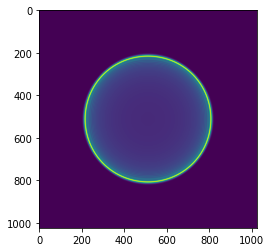

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# read the input (wavefield N x M) file
input = np.loadtxt('wavefield/wavefield.txt')

# process data e generate the plot
plt.imshow(input)
plt.show()